In [1]:
%config InlineBackend.figure_formats = ['svg']
import os

STATIC_WEB_PAGE = {"EXECUTE_NB", "READTHEDOCS"}.intersection(os.environ)

```{autolink-concat}
```

::::{margin}
:::{card} 3D visualization of Riemann sheets
TR-999
^^^
Follow-up to [TR-004](004.ipynb), where we investigate and reproduce the Riemann sheets shown in [Fig.&nbsp;50.1](https://pdg.lbl.gov/2023/reviews/rpp2022-rev-resonances.pdf#page=2) and [50.2](https://pdg.lbl.gov/2023/reviews/rpp2022-rev-resonances.pdf#page=4) of the PDG.
:::
::::

# Riemann sheets

<!-- cspell:disable -->

In [2]:
%pip install -q ampform==0.14.6 plotly==5.17.0 sympy==1.12

Note: you may need to restart the kernel to use updated packages.


First, we formulate the $T$&nbsp;matrix in terms of a $K$&nbsp;matrix. There are two ways to do this and we associate the one with the $+$ with **Sheet I** and the one with $-$ with **Sheet II**.

In [3]:
from __future__ import annotations

import warnings

import numpy as np
import plotly.graph_objects as go
import sympy as sp
from ampform.io import aslatex
from ampform.sympy import UnevaluatedExpression, implement_doit_method
from ampform.sympy.math import create_expression
from IPython.display import Math

warnings.filterwarnings("ignore")

Note that this the above inversion is equivalent to [Eq.&nbsp;(50.31)](https://pdg.lbl.gov/2023/reviews/rpp2022-rev-resonances.pdf#page=4):

$$
T = (1 \pm iK\rho)^{-1}K.
$$

As an aside, we also define a special expression class for a square root where you can choose the sign for negative arguments. This can be used later for the phase space factor&nbsp;$\rho$.

In [4]:
@implement_doit_method
class SignedSqrt(UnevaluatedExpression):
    is_commutative = True
    is_real = False

    def __new__(cls, z, **hints) -> SignedSqrt:
        return create_expression(cls, z, **hints)

    def evaluate(self) -> sp.Expr:
        z = self.args[0]
        return sp.sqrt(abs(z)) * sp.exp(sp.I * PosArg(z) / 2)

    def _latex(self, printer, *args) -> str:
        z = printer._print(self.args[0])
        return Rf"\sqrt[+]{{{z}}}"


@implement_doit_method
class PosArg(UnevaluatedExpression):
    is_commutative = True

    def __new__(cls, z, **hints) -> SignedSqrt:
        return create_expression(cls, z, **hints)

    def evaluate(self) -> sp.Expr:
        z = self.args[0]
        arg = sp.arg(z)
        return sp.Piecewise(
            (arg + 2 * sp.pi, sp.im(z) < 0),
            (arg, True),
        )

    def _latex(self, printer, *args) -> str:
        z = printer._print(self.args[0])
        return Rf"\arg^+\left({z}\right)"


z = sp.Symbol("z", complex=True)
Math(aslatex({e: e.evaluate() for e in [SignedSqrt(z), PosArg(z)]}))

<IPython.core.display.Math object>

This gives us all the ingredients to formulate expressions for the parametrization of the matrix elements.
> **Note**
>  In the following example we assume that $l$=0 

## Define phasespacefactor for non-equal masses 

In [5]:
@implement_doit_method
class NonEqualPhspFactor(UnevaluatedExpression):
    is_commutative = True
    is_real = False

    def __new__(cls, s, m1, m2, **hints) -> PhspFactor:
        return create_expression(cls, s, m1, m2, sign=+1, *hints)

    def evaluate(self) -> sp.Expr:
        s, m1, m2 = self.args
        return SignedSqrt((s - ((m1 + m2) ** 2)) * (s - (m1 - m2) ** 2)/s**2)

    def _latex(self, printer: LatexPrinter, *args) -> str:
        s = printer._print(self.args[0])
        sign = "+"
        return Rf"\rho^{{{sign}}}\left({s}\right)"


s, m_a, m_b = sp.symbols("s m_a m_b")
phsp_nonequal_mass = NonEqualPhspFactor(s, m_a, m_b)
Math(aslatex({phsp_nonequal_mass: phsp_nonequal_mass.doit(deep=False)}))

<IPython.core.display.Math object>

## Chew-Mandelstamm function  

### Define break-up momentum 

In [15]:
@implement_doit_method
class Breakup_Momentum_Signedsqrt(UnevaluatedExpression):
    is_commutative = True
    is_real = False

    def __new__(cls, s, m_a, m_b, **hints) -> PhspFactor:
        return create_expression(cls, s, m_a, m_b, sign=+1, **hints)

    def evaluate(self) -> sp.Expr:
        s, m_a, m_b = self.args
        return SignedSqrt(
            ((s - (m_a + m_b) ** 2) * (s - (m_a - m_b) ** 2) / (s*4))
        )

    def _latex(self, printer: LatexPrinter, *args) -> str:
        s = printer._print(self.args[0])
        sign = "+"
        return Rf"q^{{{sign}}}\left({s}\right)"


breakup_momentum = Breakup_Momentum_Signedsqrt(s, m_a, m_b)
Math(aslatex({breakup_momentum: breakup_momentum.doit(deep=False)}))

<IPython.core.display.Math object>

In [16]:
def Chew_Mandelstamm(s, m1, m2):
    q_break = Breakup_Momentum_Signedsqrt(s, m1, m2)
    return (
               1/(16* (sp.pi) ** 2)
        * (
            (2*q_break/sp.sqrt(s))*sp.log((m1**2 + m2**2 - s + 2 * sp.sqrt(s) * q_break)/(2*m1*m2))
            - (m1**2 - m2**2) * (1 / s - 1 / (m1 + m2) ** 2) * sp.log(m1 / m2)
        )
    )


chew_mandelstamm = Chew_Mandelstamm(s, m_a, m_b)
Math(aslatex(chew_mandelstamm))

<IPython.core.display.Math object>

## Alternative definition of Chew Mandelstamm 
By J. L. Basdevant and Edmond L. Berger
(Phys. Rev. D 16, 657 – Published 1 August 1977)

In [17]:
def Chew_Mandelstamm_BB(s, Mi, mi):
    rho = phsp_nonequal_mass 
    return (
        1/sp.pi +
        (Mi**2 - mi**2)/(sp.pi * s) * sp.ln(mi/Mi) -
        (Mi**2 + mi**2)/(sp.pi * (Mi**2 - mi**2)) * sp.ln(mi/Mi) +
        rho/sp.pi * sp.ln(
            (sp.sqrt((Mi + mi)**2 - s) - sp.sqrt((Mi - mi)**2 - s)) /
            (sp.sqrt((Mi + mi)**2 - s) + sp.sqrt((Mi - mi)**2 - s))
        )
    )

chew_mandelstamm_bb = Chew_Mandelstamm_BB(s, m_a, m_b)
Math(aslatex(chew_mandelstamm_bb))

<IPython.core.display.Math object>

## Plot Chew Mandelstamm function 

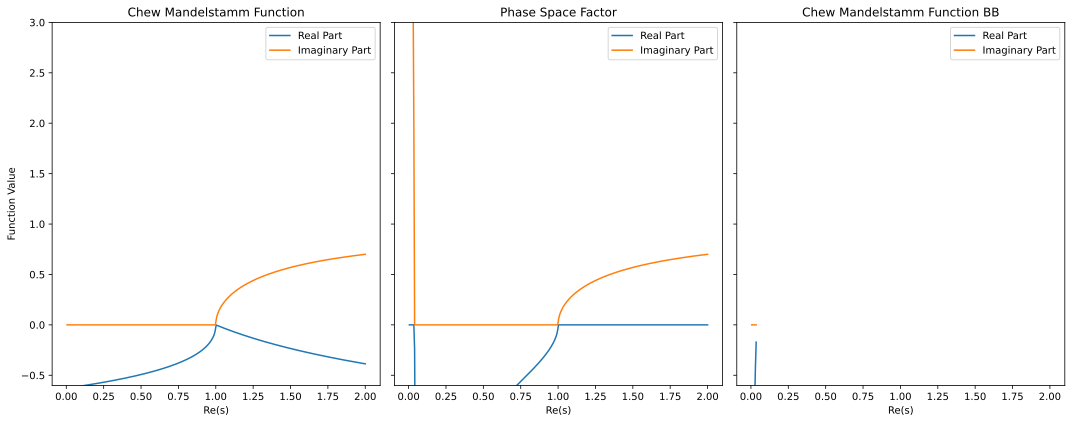

In [22]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt


Chew_Mandelstamm_func = sp.lambdify((s, m_a, m_b), Chew_Mandelstamm(s, m_a, m_b).doit(), 'numpy')
Chew_Mandelstamm_func_BB = sp.lambdify((s, m_a, m_b), Chew_Mandelstamm_BB(s, m_a, m_b).doit(), 'numpy')
Phsp_func = sp.lambdify((s, m_a, m_b), NonEqualPhspFactor(s, m_a, m_b).doit(), 'numpy')

s_values = np.linspace(0, 2, 400)
m_a_value = 0.6
m_b_value = 0.4
y_max = 3
y_min = -0.6
chew_mandelstamm_real = 16 * np.pi * np.real(Chew_Mandelstamm_func(s_values, m_a_value, m_b_value))
chew_mandelstamm_imag = 16 * np.pi * np.imag(Chew_Mandelstamm_func(s_values, m_a_value, m_b_value))
chew_mandelstamm_real_BB = np.real(Chew_Mandelstamm_func_BB(s_values, m_a_value, m_b_value))
chew_mandelstamm_imag_BB = np.imag(Chew_Mandelstamm_func_BB(s_values, m_a_value, m_b_value))

Phsp_real = np.real(1j*Phsp_func(s_values, m_a_value, m_b_value))
Phsp_imag = np.imag(1j*Phsp_func(s_values, m_a_value, m_b_value))

fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey=True, sharex=True)

axs[0].plot(s_values, chew_mandelstamm_real, label='Real Part')
axs[0].plot(s_values, chew_mandelstamm_imag, label='Imaginary Part')
axs[0].set_xlabel('Re(s)')
axs[0].set_ylabel('Function Value')
axs[0].set_title('Chew Mandelstamm Function')
axs[0].legend()

axs[0].set_ylim(y_min,y_max)
axs[1].plot(s_values, Phsp_real, label='Real Part')
axs[1].plot(s_values, Phsp_imag, label='Imaginary Part')
axs[1].set_xlabel('Re(s)')
axs[1].set_title('Phase Space Factor')
axs[1].legend()

axs[2].plot(s_values, chew_mandelstamm_real_BB, label='Real Part')
axs[2].plot(s_values, chew_mandelstamm_imag_BB, label='Imaginary Part')
axs[2].set_xlabel('Re(s)')
axs[2].set_title('Chew Mandelstamm Function BB')
axs[2].legend()

plt.tight_layout()

plt.show()



## Define parameters values for plotting 

## Add K Matrix definition   

In [ ]:
n_channels = 1
I = sp.Identity(n_channels)
K = sp.MatrixSymbol("K", n_channels, n_channels)
rho = sp.MatrixSymbol("rho", n_channels, n_channels)

In [ ]:
T = (I - sp.I* K * rho).inv() * K
T

In [ ]:
T_explicit = T.as_explicit()
T_explicit

No Blatt-Weisskopf-Formfactors because $l=0$

In [ ]:
gamma_R, m_R, w_R = sp.symbols("gamma_R m_R Gamma_R")
k_expr = (gamma_R**2 * m_R * w_R) / (s - m_R**2)

In [ ]:
rho_expressions = {
    K[0, 0]: k_expr,
    rho[0, 0]: NonEqualPhspFactor(s, m_a, m_b),
}
Math(aslatex(rho_expressions))

In [ ]:
cm_expressions = {
    K[0, 0]: k_expr,
    rho[0, 0]:-sp.I*16 * sp.pi * Chew_Mandelstamm(s, m_a, m_b),
}
Math(aslatex(cm_expressions))

In [ ]:
cm_expressions_conj = {
    K[0, 0]: k_expr,
    rho[0, 0]:-sp.I*16 * sp.pi * Chew_Mandelstamm(s, m_a, m_b).conjugate(),
}
Math(aslatex(cm_expressions_conj))

In [ ]:
T_rho_expr = T_explicit[0, 0].xreplace(rho_expressions)
T_cm_expr = T_explicit[0, 0].xreplace(cm_expressions)
T_cm_expr_conj = T_explicit[0, 0].xreplace(cm_expressions_conj)

In [ ]:
T_cm_expr

## Second Riemann sheet
To get to the physical/unpysical Riemann sheet one uses XXXX which is derived from Schwarz reflection priciple

In [ ]:
args = (s, m_a, m_b, m_R, w_R, gamma_R)
T_rho_func = sp.lambdify(args, T_rho_expr.doit())
T_cm_func = sp.lambdify(args, T_cm_expr.doit())
T_cm_func_conj = sp.lambdify(args, T_cm_expr_conj.doit())

In [ ]:
import numpy as np

epsilon = 1e-5
x = np.linspace(0, 2, num=200)
y_positive = np.linspace(epsilon, 1, num=100)
y_negative = -y_positive  
X, Yn = np.meshgrid(x, y_negative)
_, Yp = np.meshgrid(x, y_positive)  
Zn = X + Yn * 1j
Zp = X + Yp * 1j

m1 = 0.3
m2 = 0.4
m_res = 1
w_res = 0.1
gamma_R1 = 1

Tp = T_rho_func(Zp**2, m1, m2, m_res, w_res, gamma_R1)
Tn = T_rho_func(Zn**2, m1, m2, m_res, w_res, gamma_R1)

Tp_cm = T_cm_func(Zp**2, m1, m2, m_res, w_res, gamma_R1)
Tn_cm = T_cm_func(Zn**2, m1, m2, m_res, w_res, gamma_R1)

Tp_cm_conj = T_cm_func_conj(Zp**2, m1, m2, m_res, w_res, gamma_R1)
Tn_cm_conj = T_cm_func_conj(Zn**2, m1, m2, m_res, w_res, gamma_R1)
vmax = 0.8


In [ ]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

axs[0].plot(x, Tp_cm[0].imag)
axs[0].plot(x, Tn_cm_conj[0].imag)
axs[0].set_xlabel('Re(s)')
axs[0].set_ylabel('Function Value')
axs[0].set_title('Chew Mandelstamm Function')

axs[1].plot(x, Tp[0].imag)
axs[1].plot(x, Tn[0].imag)
axs[1].set_xlabel('Re(s)')
axs[1].set_title('Phsp Function')


plt.tight_layout()

plt.show()



In [ ]:
def sty(t, vmax, sheet_color, opacity):
    return {
        "cmin": -vmax,
        "cmax": +vmax,
        "colorscale": [[0, sheet_color], [1, sheet_color]],
        "surfacecolor": t.imag,
        "opacity": opacity,
    }



color_unphysical = 'red'
color_physical = 'blue'
opacity_value = 0.8

Sn_imag = go.Surface(x=X, y=Yn, z=Tn.imag, **sty(Tn, vmax, color_unphysical, opacity_value), name="Unphysical", showscale=False)
Sp_imag = go.Surface(x=X, y=Yp, z=Tp.imag, **sty(Tp, vmax, color_physical, opacity_value), name="Physical", showscale=False)

Sn_imag_cm = go.Surface(x=X, y=Yn, z=Tn_cm.imag, **sty(Tn_cm, vmax, color_unphysical, opacity_value), name="Unphysical", showscale=False)
Sp_imag_cm = go.Surface(x=X, y=Yp, z=Tp_cm.imag, **sty(Tp_cm, vmax, color_physical, opacity_value), name="Physical", showscale=False)

Sn_imag_cm_conj = go.Surface(x=X, y=Yn, z=Tn_cm_conj.imag, **sty(Tn_cm_conj, vmax, color_unphysical, opacity_value), name="Unphysical", showscale=False)
Sp_imag_cm_conj = go.Surface(x=X, y=Yp, z=Tp_cm_conj.imag, **sty(Tp_cm_conj, vmax, color_physical, opacity_value), name="Physical", showscale=False)

y = Yp[0]
z = x + y * 1j

line_real = go.Scatter3d(
    x=x,
    y=y,
    z=Tp[0].real,
    mode="lines", 
    line={"color": "black", "width": 2.5},
)

line_cm_real = go.Scatter3d(
    x=x,
    y=y,
    z=Tn_cm_conj[0].real,
    mode="lines",
    line={"color": "black", "width": 2.5},
)

point_x = m1 + m2
point_y = 0  
point_z = 0

single_point = go.Scatter3d(
    x=[point_x],
    y=[point_y],
    z=[point_z],
    mode="markers",
    marker={"color": "black", "size": 2},
    name="Threshold"
)

fig_imag = go.Figure(data=[Sn_imag, Sp_imag, line_real])
fig_imag.update_layout(height=550, width=600,   title_text=' Imaginary part of T function with Phsp Sheet I+II')
fig_imag.update_scenes(
    xaxis_title_text="Re s",
    yaxis_title_text="Im s",
    zaxis_range=[-vmax, +vmax],
)


fig_imag_cm = go.Figure(data=[Sn_imag_cm_conj, Sp_imag_cm,line_cm_real])
fig_imag_cm.update_layout(height=550, width=600, title_text='Imaginary part of T function with CM Conjugate Sheet I+II')
fig_imag_cm.update_scenes(xaxis_title_text="Re s", yaxis_title_text="Im s", zaxis_range=[-vmax, vmax])
fig_imag.add_trace(single_point)
fig_imag_cm.add_trace(single_point)

fig_imag.show()
fig_imag_cm.show()